# The Advanced Computing Center for Research and Education
The Advanced Computing Center for Research and Education (ACCRE) is a computer cluster serving the high-performance computing needs of research for Vanderbilt University. In this data question, you will be analyzing data on jobs run on ACCRE's hardware.

When a job is submitted to ACCRE, it goes through the slurm scheduler, which tracks and manages compute and memory resources. It is hypothesized that the slurm scheduler is processing so many job completions so frequently that it sometimes becomes unresponsive to commands from users trying to schedule new jobs or check job status. This is a particularly bad problem for clients who use automated submission systems, such as members of the Open Science Grid. The goal of this project is to investigate and potentially confirm that hypothesis that lots of job completions in a short time period are causing the scheduler to be unresponsive, and determine the rough threshold at which it becomes an issue.

You have been provided three datasets for this task:

- fullsample.csv: This file contains output for jobs run through the slurm scheduler.
- slurm_wrapper_ce5.log and slurm_wrapper_ce6.log: Logs of every slurm command that a pair of servers, ce5 and ce6, executed, how long it took, and if it succeeded. These servers connect ACCRE's local cluster to the Open Science Grid and submit jobs to slurm on behalf of the grid.

To get started, answer the following questions using just the fullsample.csv jobs dataset:

1. Calculate some descriptive statistics for how many jobs per hour are being completed. What does the completions per hour look like over the time span of the dataset? Are there weekly trends, and has it been increasing over the last year?


2. Does the job state affect completions per hour? i.e. if I only look at jobs with exit code 0:0 in the "COMPLETED" state, is that a similar number of completions per hour as with all jobs, failed or cancelled? This will indicate if the load on the scheduler is by user design or is a result of users not sufficiently testing their jobs before submitting very large arrays. We also expect that most job completions will be in the "production" partition, but is this actually true?



In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import calendar

In [2]:
fs_df = pd.read_csv('../data/fullsample.csv')
fs_df = fs_df[fs_df['END'] != 'Unknown'] # drop these 651 rows, all have EXITCODE 0:0

#change the format of the date/time
fs_df['BEGIN'] = pd.to_datetime(fs_df['BEGIN'], format='%Y-%m-%dT%H:%M:%S')
fs_df['END'] = pd.to_datetime(fs_df['END'], format='%Y-%m-%dT%H:%M:%S')
#fs_df.head(3)

In [4]:
#change the format of requested memory and chnage its type to int
fs_df['REQMEM'] = fs_df['REQMEM'].str[0:-2].astype('int')

#change the used momory 
fs_df['USEDMEM'] = fs_df['USEDMEM'].apply(lambda x: x[0:-1] if x[-1] == 'M' else '0', ).astype(float)
#fs_df.head(3)

In [26]:
#setting the index to END
end_time=fs_df.set_index('END')
end_time.head(3)

,JOBID,STATE,BEGIN,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
END,,,,,,,,,,,
2021-09-05 11:36:32,30853133,COMPLETED,2021-08-06 11:36:09,262144,20604.62,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2021-09-05 19:04:53,30858137,COMPLETED,2021-08-06 19:04:39,204800,57553.77,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
2021-09-07 20:52:55,30935078,COMPLETED,2021-08-09 16:52:51,65536,20577.96,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0


In [27]:
#subsetting the data to the completed ones 
completed=end_time.loc[end_time['STATE']=='COMPLETED']
completed.head(3)

,JOBID,STATE,BEGIN,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
END,,,,,,,,,,,
2021-09-05 11:36:32,30853133,COMPLETED,2021-08-06 11:36:09,262144,20604.62,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2021-09-05 19:04:53,30858137,COMPLETED,2021-08-06 19:04:39,204800,57553.77,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
2021-09-07 20:52:55,30935078,COMPLETED,2021-08-09 16:52:51,65536,20577.96,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0


In [28]:
#completed number of jobs in 24 hours 
completed['JOBID'].resample(pd.Timedelta('24 hours')).count()

END
2020-10-01    33263
2020-10-02    30356
2020-10-03    15346
2020-10-04    17532
2020-10-05    24119
              ...  
2021-10-03     1561
2021-10-04      614
2021-10-05      727
2021-10-06      265
2021-10-07      320
Freq: D, Name: JOBID, Length: 372, dtype: int64

In [29]:
#completed number of jobs in 1 hour
completed['JOBID'].resample(pd.Timedelta('1 hour')).count()

END
2020-10-01 00:00:00     421
2020-10-01 01:00:00    1080
2020-10-01 02:00:00    1137
2020-10-01 03:00:00    1018
2020-10-01 04:00:00    1244
                       ... 
2021-10-07 16:00:00       8
2021-10-07 17:00:00       8
2021-10-07 18:00:00       8
2021-10-07 19:00:00       8
2021-10-07 20:00:00       6
Freq: H, Name: JOBID, Length: 8925, dtype: int64

In [30]:
completed_by_hour=completed.resample('H').count()
completed_by_hour.head(3)

,JOBID,STATE,BEGIN,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
END,,,,,,,,,,,
2020-10-01 00:00:00,421,421,421,421,421,421,421,421,421,421,421
2020-10-01 01:00:00,1080,1080,1080,1080,1080,1080,1080,1080,1080,1080,1080
2020-10-01 02:00:00,1137,1137,1137,1137,1137,1137,1137,1137,1137,1137,1137


In [31]:
completed_jobs=completed_by_hour['JOBID']

In [32]:
completed_jobs

END
2020-10-01 00:00:00     421
2020-10-01 01:00:00    1080
2020-10-01 02:00:00    1137
2020-10-01 03:00:00    1018
2020-10-01 04:00:00    1244
                       ... 
2021-10-07 16:00:00       8
2021-10-07 17:00:00       8
2021-10-07 18:00:00       8
2021-10-07 19:00:00       8
2021-10-07 20:00:00       6
Freq: H, Name: JOBID, Length: 8925, dtype: int64

In [37]:
#1 job is canceled by user 9204 
fs_df.loc[fs_df['STATE'] == 'CANCELLED by 9204', 'EXITCODE'].value_counts()

1:0    1
Name: EXITCODE, dtype: int64

In [59]:
#counts of completed ones
fs_df.loc[fs_df['STATE'] == 'COMPLETED'].value_counts()
fs_df.loc[fs_df['STATE'] == 'COMPLETED'].value_counts().sum()

7375084

In [38]:
# counts of completed ones and their exit code (0:0)
fs_df.loc[fs_df['STATE'] == 'COMPLETED', 'EXITCODE'].value_counts()

0:0    7375084
Name: EXITCODE, dtype: int64

In [40]:
# filter down to only COMPLETED state
fs_comp = fs_df[fs_df['STATE'] == 'COMPLETED']
fs_comp.head(3)

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
1,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144,20604.62,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800,57553.77,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09 16:52:51,2021-09-07 20:52:55,65536,20577.96,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0


In [43]:
#counts of completions per hour 
comp_per_hour = (fs_comp.set_index('END')
                       .sort_values('END', ascending = True)
                       .rolling('1h')
                        ['JOBID']
                        .count()
                )
comp_per_hour

END
2020-10-01 00:10:15    1.0
2020-10-01 00:12:58    2.0
2020-10-01 00:13:31    3.0
2020-10-01 00:17:23    4.0
2020-10-01 00:17:53    5.0
                      ... 
2021-10-07 20:11:21    9.0
2021-10-07 20:17:24    9.0
2021-10-07 20:26:01    8.0
2021-10-07 20:32:45    9.0
2021-10-07 20:41:11    9.0
Name: JOBID, Length: 7375084, dtype: float64

In [45]:
# define a function to calculate total hours of a timedelta
def td_hours(timedelta):
    hours = timedelta.days*24 + timedelta.seconds/3600
    return hours

In [47]:
# overall completions per hour 
completions = len(fs_comp)
time_diff = (fs_df['END'].max() - fs_df['END'].min())
jobs_per_hour = completions/td_hours(time_diff)
print(round(jobs_per_hour, 1), 'completions per hour')


826.4 completions per hour


In [53]:
#completions per hour per week
comp_per_hour_by_week = (fs_comp.groupby(
                                    pd.Grouper(key = 'END', freq = 'W')) # Group by week
                                 ['JOBID'] # Counting job ids
                                 .count()/168 # divide count by 168 hours in a week
                        )
comp_per_hour_by_week.head(3)

END
2020-10-04     574.386905
2020-10-11    1221.565476
2020-10-18     672.672619
Freq: W-SUN, Name: JOBID, dtype: float64

In [54]:
# rename two columns
comp_per_hour_by_week = (comp_per_hour_by_week.reset_index()
                                              .rename(columns = {'END': 'WEEK OF', 
                                                                 'JOBID': 'COMPLETIONS PER HOUR'}
                                                     )
                        )
comp_per_hour_by_week.head(3)

,WEEK OF,COMPLETIONS PER HOUR
0,2020-10-04,574.386905
1,2020-10-11,1221.565476
2,2020-10-18,672.672619


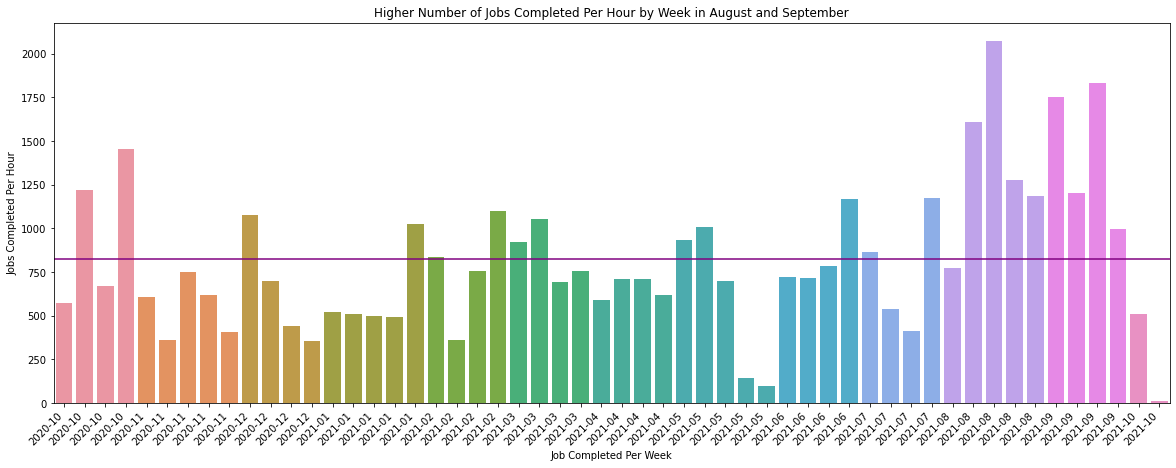

In [64]:
# Plot completions per hour by week, colored by month
fig, ax = plt.subplots(figsize=(20,7))

x_dates = comp_per_hour_by_week['WEEK OF'].dt.strftime('%Y-%m')

sns.barplot(x = 'WEEK OF',
            y = 'COMPLETIONS PER HOUR',
            data = comp_per_hour_by_week,
            ax = ax,
            hue = x_dates,
            dodge = False
           )


ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.get_legend().remove()
ax.axhline(jobs_per_hour, color = 'purple')
ax.set(xlabel = 'Job Completed Per Week',
       ylabel = 'Jobs Completed Per Hour',
       title = 'Higher Number of Jobs Completed Per Hour by Week in August and September')
plt.show()

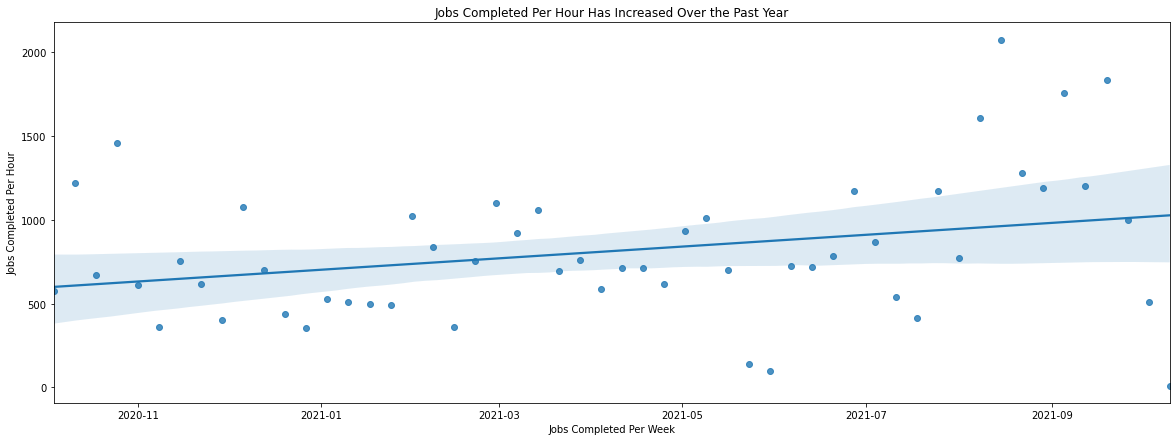

In [65]:
# Plot completions per hour by week along with trendline, which shows gradual increase over the year
fig, ax = plt.subplots(figsize=(20,7))

ax.xaxis.update_units(comp_per_hour_by_week['WEEK OF'])

sns.regplot(x = ax.xaxis.convert_units(comp_per_hour_by_week['WEEK OF']),
            y = 'COMPLETIONS PER HOUR',
            data = comp_per_hour_by_week,
            ax = ax,
           )

ax.set(xlabel = 'Jobs Completed Per Week',
       ylabel = 'Jobs Completed Per Hour',
       title = 'Jobs Completed Per Hour Has Increased Over the Past Year')
plt.show()

In [68]:
#number of jobs are increasing, the model shows a slope of 1.15 jobs per hour per day
gen_lin_reg_model = (sm.GLM(endog = comp_per_hour_by_week['COMPLETIONS PER HOUR'],
                      exog = sm.add_constant(comp_per_hour_by_week['WEEK OF'].map(datetime.toordinal)),
                      family = sm.families.Gaussian())
               .fit())

print(gen_lin_reg_model.summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     COMPLETIONS PER HOUR   No. Observations:                   54
Model:                              GLM   Df Residuals:                       52
Model Family:                  Gaussian   Df Model:                            1
Link Function:                 identity   Scale:                      1.6475e+05
Method:                            IRLS   Log-Likelihood:                -399.93
Date:                  Thu, 28 Oct 2021   Deviance:                   8.5672e+06
Time:                          14:22:14   Pearson chi2:                 8.57e+06
No. Iterations:                       3                                         
Covariance Type:              nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.481e+05   3.74e+05

In [79]:
#job completions per hour per day 
comp_per_hour_by_day = (fs_comp.groupby(
                                 pd.Grouper(key = 'END', freq = 'D')) # Group by day
                                 ['JOBID'] # Counting job ids
                                 .count()/24 # divide count by 24 hours in a day
                        )
comp_per_hour_by_day

END
2020-10-01    1385.958333
2020-10-02    1264.833333
2020-10-03     639.416667
2020-10-04     730.500000
2020-10-05    1004.958333
                 ...     
2021-10-03      65.041667
2021-10-04      25.583333
2021-10-05      30.291667
2021-10-06      11.041667
2021-10-07      13.333333
Freq: D, Name: JOBID, Length: 372, dtype: float64

In [71]:
# display with renamed columns
comp_per_hour_by_day = (comp_per_hour_by_day.reset_index()
                                              .rename(columns = {'END': 'DAY', 
                                                                 'JOBID': 'COMPLETIONS PER HOUR'}
                                                     )
                        )

In [74]:
# Add weekday and weekday number to completions per hour by day
comp_per_hour_by_day['WEEKDAY'] = comp_per_hour_by_day['DAY'].apply(lambda x: calendar.day_name[x.weekday()])
comp_per_hour_by_day['WEEKDAY NUMBER'] = comp_per_hour_by_day['DAY'].apply(lambda x: x.weekday()+1)
comp_per_hour_by_day

,DAY,COMPLETIONS PER HOUR,WEEKDAY,WEEKDAY NUMBER
0,2020-10-01,1385.958333,Thursday,4
1,2020-10-02,1264.833333,Friday,5
2,2020-10-03,639.416667,Saturday,6
3,2020-10-04,730.500000,Sunday,7
4,2020-10-05,1004.958333,Monday,1
...,...,...,...,...
367,2021-10-03,65.041667,Sunday,7
368,2021-10-04,25.583333,Monday,1
369,2021-10-05,30.291667,Tuesday,2
370,2021-10-06,11.041667,Wednesday,3


In [75]:
# Aggregate by weekday
comp_per_hour_weekday = comp_per_hour_by_day.groupby(['WEEKDAY NUMBER', 'WEEKDAY'], as_index = False)['COMPLETIONS PER HOUR'].mean()
comp_per_hour_weekday

#highest number of completions during Monday_Wednesday

,WEEKDAY NUMBER,WEEKDAY,COMPLETIONS PER HOUR
0,1,Monday,878.555031
1,2,Tuesday,1019.834906
2,3,Wednesday,926.651730
3,4,Thursday,795.691358
4,5,Friday,805.452044
5,6,Saturday,664.910377
6,7,Sunday,691.913522


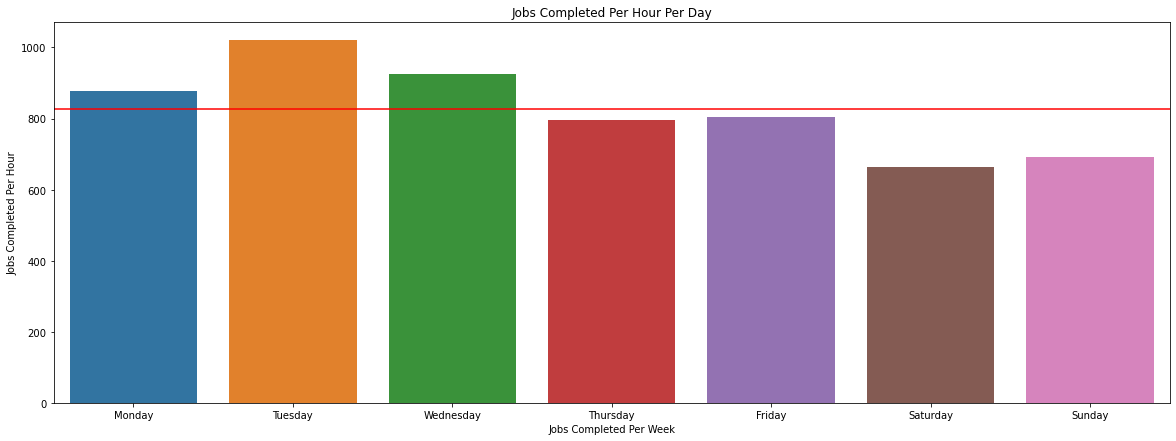

In [77]:
# Plot completions per hour by weekday
fig, ax = plt.subplots(figsize=(20,7))

sns.barplot(x = 'WEEKDAY',
            y = 'COMPLETIONS PER HOUR',
            data = comp_per_hour_weekday,
            ax = ax,
           )

ax.axhline(jobs_per_hour, color = 'red')
ax.set(xlabel = 'Jobs Completed Per Week',
       ylabel = 'Jobs Completed Per Hour',
       title = 'Jobs Completed Per Hour Per Day')
plt.show()

#Monday through Wednesday are the days that are above the average completions per hour per day

<BarContainer object of 7 artists>

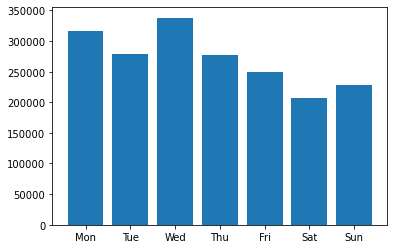

In [81]:
jobs_weekday = [len(fs_df[fs_df['BEGIN'].dt.day == x]) for x in range(1,8)]
ax.axhline(jobs_per_hour, color = 'red')
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], jobs_weekday)


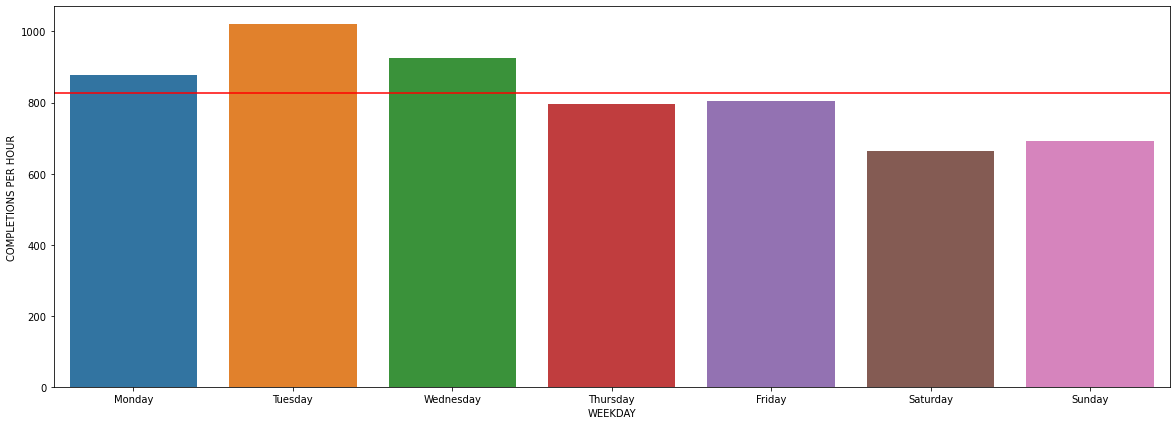

In [84]:
fig, ax = plt.subplots(figsize=(20,7))
sns.barplot(x = 'WEEKDAY',
            y = 'COMPLETIONS PER HOUR',
            data = comp_per_hour_weekday,
            ax = ax,
           )
ax.axhline(jobs_per_hour, color = 'red')
plt.show()


In [103]:
#counts of exitcodes
fs_df.value_counts('EXITCODE')

EXITCODE
0:0      7383829
1:0         4958
0:15        1887
0:125       1739
0:9         1361
2:0          508
0:7          389
121:0         89
127:0         88
13:0          68
24:0          67
0:11          35
38:0          32
28:0          29
6:0           27
126:0         24
0:6           18
0:2           16
29:0          12
7:0           12
16:0           9
59:0           8
9:0            4
0:40           4
125:0          3
8:0            3
0:105          2
0:12           1
67:0           1
85:0           1
0:98           1
76:0           1
103:0          1
4:0            1
116:0          1
43:0           1
3:0            1
11:0           1
30:0           1
0:8            1
dtype: int64

In [92]:
#counts of state
fs_df.value_counts('STATE')

STATE
COMPLETED              7375084
CANCELLED                 9055
FAILED                    3766
CANCELLED by 9201         1776
OUT_OF_MEMORY             1739
                        ...   
CANCELLED by 762866          1
CANCELLED by 858449          1
CANCELLED by 494371          1
CANCELLED by 485036          1
CANCELLED by 766637          1
Length: 143, dtype: int64

In [118]:
#gives us the specific exitcodes we want 
#fs_df[fs_df['EXITCODE'] == '0:125']
#fs_df[fs_df['EXITCODE'] == '0:7']

In [174]:
#gives us exitcodes and states
#fs_df[fs_df['STATE'].str.match(r'CANCELLED')]
#fs_df[fs_df['STATE'].str.match(r'CANCELLED')].value_counts('EXITCODE')
#fs_df[fs_df['STATE'].str.match(r'FAILED')].value_counts('EXITCODE')
fs_can = fs_df[fs_df['STATE'] == 'CANCELLED']
fs_fail=fs_df[fs_df['STATE'] == 'FAILED']

In [173]:
#counts of cancelled jobs per hour 
can_per_hour = (fs_can.set_index('END')
                       .sort_values('END', ascending = True)
                       .rolling('1h')
                        ['JOBID']
                        .count()
                )
#can_per_hour

<AxesSubplot:xlabel='END'>

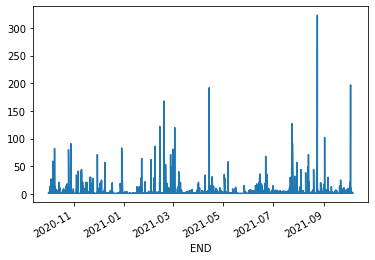

In [176]:
can_per_hour.plot()

In [175]:
#counts of cancelled jobs per hour 
fail_per_hour = (fs_fail.set_index('END')
                       .sort_values('END', ascending = True)
                       .rolling('1h')
                        ['JOBID']
                        .count()
                )
#fail_per_hour

<AxesSubplot:xlabel='END'>

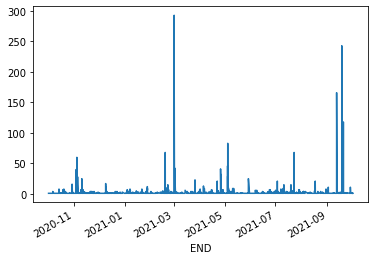

In [177]:
fail_per_hour.plot()

In [157]:
fs_df['STATE'] = fs_df['STATE'].replace({r'CANCELLED by (\d*)', 'CANCELLED by USER'})
fs_df['STATE']

1          COMPLETED
2          COMPLETED
3          COMPLETED
4          COMPLETED
5          COMPLETED
             ...    
7395880    COMPLETED
7395881    COMPLETED
7395882    COMPLETED
7395883    COMPLETED
7395884    COMPLETED
Name: STATE, Length: 7395234, dtype: object

In [158]:
fs_df.groupby('STATE')['PARTITION', 'EXITCODE'].count()

<ipython-input-158-062ed03d77f6>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  fs_df.groupby('STATE')['PARTITION', 'EXITCODE'].count()


,PARTITION,EXITCODE
STATE,,
CANCELLED,9055,9055
CANCELLED by 0,474,474
CANCELLED by 111694,1,1
CANCELLED by 160027,1,1
CANCELLED by 161909,4,4
...,...,...
CANCELLED by 9221,71,71
COMPLETED,7375084,7375084
FAILED,3766,3766


In [147]:
fs_df.groupby('PARTITION')['STATE', 'EXITCODE'].count()

<ipython-input-147-603c000bb2cf>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  fs_df.groupby('PARTITION')['STATE', 'EXITCODE'].count()


,STATE,EXITCODE
PARTITION,,
cgw-capra1,153,153
cgw-cqs1,28,28
cgw-dougherty1,125,125
cgw-dsi-gw,228,228
cgw-hanuman,21,21
cgw-horus,61,61
cgw-maizie,4308,4308
cgw-platypus,376,376
cgw-sideshowbob,14,14


Next, use the two log files to determine time intervals (hours) when the scheduler was unresponsive. Do this by looking for records that are the "sbatch" command from user 9204 that have return code 1 and an execution time of ~20 seconds (at least more than 15). These are commands where the scheduler timed out in responding.

3. Calculate some descriptive statistics about how often the scheduler was unresponsive, how long these periods of time were, and create a time series plot of when the scheduler was having difficulties.


4. Finally, combine the time series information from the two datasets together to see how well correlated heavy job-completion load is with the unresponsiveness, and to see if there is some threshold of job completions per hour that generally results in unresponsiveness.

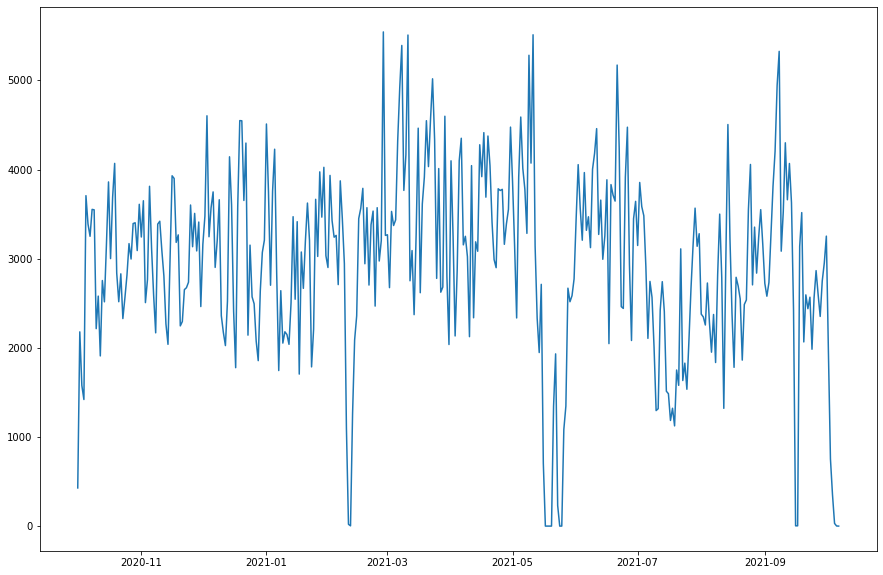

In [114]:
begin_load_df = fs_df[fs_df['PARTITION'] == 'production'][['BEGIN']].rename(columns={'BEGIN':'TIME'})
begin_load_df['process'] = 1
end_load_df = fs_df[fs_df['PARTITION'] == 'production'][['END']].rename(columns={'END':'TIME'})
end_load_df['process'] = -1
load_df = begin_load_df.append(end_load_df)

resample_interval = "D" #day
fs_ts = pd.Series(list(load_df['process']), index=list(load_df['TIME']))
fs_resample = fs_ts.resample(resample_interval).sum().to_frame().cumsum()

plt.figure(figsize=(15, 10))
fs_ts = pd.Series(list(load_df['process']), index=list(load_df['TIME']))
plt.plot(fs_resample.index, fs_resample[0])

In [6]:
cs5_orig_df = pd.read_csv('../data/ce5_9024_sbatch.csv')
cs6_orig_df = pd.read_csv('../data/ce6_9024_sbatch.csv')
#cs5_orig_df.head(3)
#cs6_orig_df.head(3)

In [9]:
#keeping only these columns 
cs5_orig_df = cs5_orig_df[['TIME', 'RETRY', 'EXETIME', 'RETURNCODE']]
cs6_orig_df = cs6_orig_df[['TIME', 'RETRY', 'EXETIME', 'RETURNCODE']]

#kepping only the digit in these columns and changing its type to int
cs5_orig_df['RETRY'] = cs5_orig_df['RETRY'].str.extract(r'(\d)').astype(int)
cs6_orig_df['RETRY'] = cs6_orig_df['RETRY'].str.extract(r'(\d)').astype(int)
cs5_orig_df['RETURNCODE'] = cs5_orig_df['RETURNCODE'].str.extract(r'(\d)').astype(int)
cs6_orig_df['RETURNCODE'] = cs6_orig_df['RETURNCODE'].str.extract(r'(\d)').astype(int)

#chnaging the date format 
cs5_orig_df['TIME'] = pd.to_datetime(cs5_orig_df['TIME'], format='%Y-%m-%dT%H:%M:%S')
cs6_orig_df['TIME'] = pd.to_datetime(cs6_orig_df['TIME'], format='%Y-%m-%dT%H:%M:%S')

#cs5_orig_df.head(3)
#cs6_orig_df.head(3)

In [34]:
#Completed Jobs by Partition
((completed.groupby('PARTITION').agg({'PARTITION':'count'}))/completed.count())*100

,BEGIN,CPUS,EXITCODE,JOBID,NODES,PARTITION,REQMEM,REQTIME,STATE,USEDMEM,USEDTIME
PARTITION,,,,,,,,,,,
cgw-capra1,NaN,NaN,NaN,NaN,NaN,0.002047,NaN,NaN,NaN,NaN,NaN
cgw-cqs1,NaN,NaN,NaN,NaN,NaN,0.000353,NaN,NaN,NaN,NaN,NaN
cgw-dougherty1,NaN,NaN,NaN,NaN,NaN,0.001519,NaN,NaN,NaN,NaN,NaN
cgw-dsi-gw,NaN,NaN,NaN,NaN,NaN,0.003078,NaN,NaN,NaN,NaN,NaN
cgw-hanuman,NaN,NaN,NaN,NaN,NaN,0.000285,NaN,NaN,NaN,NaN,NaN
cgw-horus,NaN,NaN,NaN,NaN,NaN,0.000827,NaN,NaN,NaN,NaN,NaN
cgw-maizie,NaN,NaN,NaN,NaN,NaN,0.057830,NaN,NaN,NaN,NaN,NaN
cgw-platypus,NaN,NaN,NaN,NaN,NaN,0.005030,NaN,NaN,NaN,NaN,NaN
cgw-sideshowbob,NaN,NaN,NaN,NaN,NaN,0.000176,NaN,NaN,NaN,NaN,NaN


In [35]:
fs_df.groupby('STATE').agg({'STATE':'count'})

,STATE
STATE,
CANCELLED,9055
CANCELLED by 0,474
CANCELLED by 111694,1
CANCELLED by 160027,1
CANCELLED by 161909,4
...,...
CANCELLED by 9221,71
COMPLETED,7375084
FAILED,3766
